Using ULM fit for doing text classification on the coling classification data

In [1]:
# For using this on google collab, change the Runtime to have a GPU accellerator
# Then, uncomment and execute the line below:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [2]:
# If you are training in colab you need to write and save that to a cloud drive.
# Uncomment those if you wanna set up a drive.
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from pathlib import Path
from fastai.text.data import TextDataBunch, TextLMDataBunch
from fastai.text import language_model_learner, text_classifier_learner
from fastai.text.models.awd_lstm import AWD_LSTM
from fastai.metrics import fbeta
import pandas as pd

In [10]:
# work with paths, so if you are using a local file path
# use that as a base_dir
base_path = Path(base_dir + "coling_toxic")
base_path.ls()

[PosixPath('/content/gdrive/My Drive/fastai-v3/coling_toxic/agr_en_dev.csv'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/coling_toxic/agr_en_train.csv')]

In [11]:
df_train = pd.read_csv(base_path / 'agr_en_train.csv', header=None)
df_train.head()

,0,1,2
0,facebook_corpus_msr_1723796,Well said sonu..you have courage to stand agai...,OAG
1,facebook_corpus_msr_466073,"Most of Private Banks ATM's Like HDFC, ICICI e...",NAG
2,facebook_corpus_msr_1493901,"Now question is, Pakistan will adhere to this?",OAG
3,facebook_corpus_msr_405512,Pakistan is comprised of fake muslims who does...,OAG
4,facebook_corpus_msr_1521685,"??we r against cow slaughter,so of course it w...",NAG


In [12]:
df_train[1][1] 

"Most of Private Banks ATM's Like HDFC, ICICI etc are out of cash. Only Public sector bank's ATM working"

In [16]:
df_dev = pd.read_csv(base_path / 'agr_en_dev.csv', header=None)
df_dev.head()

,0,1,2
0,facebook_corpus_msr_451811,The quality of re made now makes me think it i...,CAG
1,facebook_corpus_msr_334368,@siva \nHow is ur mother???\nHow is ur wife???...,NAG
2,facebook_corpus_msr_331195,Also see ....hw ur RSS activist caught in Burk...,NAG
3,facebook_corpus_msr_403402,On the death of 2 jawans in LOC CROSS FIRING\n...,NAG
4,facebook_corpus_msr_379239,Modi ho ya Manmohan singh saala yeh log kuch n...,OAG


In [17]:
df_dev[1][1] 

'@siva \nHow is ur mother???\nHow is ur wife???\nHow is ur sister???\n\nHope everyone is fine....😁😁😁'

In [0]:
data_lm = TextLMDataBunch.from_df(base_path, df_train, df_dev, label_cols=2)

In [0]:
data_lm.save()

In [21]:
data_lm.show_batch()

idx,text
0,"muslims who does not know the meaning of unity and xxunk their thoughts on others xxrep 5 . all the rascals have gathered there ... xxbos ? ? we r against cow slaughter , so of course it will stop leather manufacturing if it happens . xxbos xxmaj wondering why xxmaj educated xxmaj ambassador is struggling to pay through xxmaj credit / xxmaj debit at a xxmaj decent xxmaj restaurant"
1,"ca n't xxunk between a military activity and an act of barbarism . \n \n xxmaj remember the xxup nli , bodies of whose soldiers you refused to acknowledge during kargil conflict . \n \n xxmaj so , keep your knowledge to yourself and live in your own fantasy land . xxbos xxmaj cows are definitely gon na vote for xxmaj modi ji in 2019 ;) xxbos congress"
2,xxmaj this is despicable n only a pervert will do dis n d pakis r perverts . xxbos @ xxmaj neel xxmaj patel ... xxmaj glad to know dat ur xxunk ppl still exists ... xxmaj stay blessed xxbos xxmaj president xxmaj xi xxmaj xxunk has xxunk advancing xxmaj china 's space programme to strengthen national security . xxbos xxup bjp running xxup mcd for ten years . xxmaj if
3,issued only by a qualified jurist ( xxmaj mufti ) on a request by someone who is unable to understand religious guidelines whereas the leaflet that is being circulated and presented as xxmaj fatwa is just a hard copy of an appeal signed by 46 men who believe in religious practices . xxmaj the merit of appeal can be discussed on many grounds and in many dimensions but first and
4,is not paying you . \n xxmaj do n't think of excelling your self .as you said economic survey of xxmaj india .the key figure is xxmaj india & not xxup fm . \n \n xxmaj note xxmaj ban has ruined all sectors xxunk was result of keeping boss happy . \n \n xxmaj note ban killed so many .but soldiers save you & get killed themselves


Now that we have a data buch created, we can download a pre-trained language model and train some more.

In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

Let's find a learning rate and start fine tunning the model

In [23]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


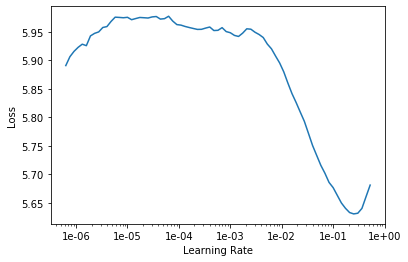

In [0]:
learn.recorder.plot(skip_end=15)

In [24]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.858479,4.506994,0.245150,00:16


In [0]:
learn.save('fit_head')

In [0]:
learn.unfreeze()

In [27]:
learn.fit_one_cycle(5, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.282601,4.318721,0.265899,00:21
1,4.113906,4.247952,0.275710,00:22
2,3.653488,4.198964,0.282884,00:24
3,2.922931,4.302004,0.286496,00:24
4,2.139960,4.490801,0.281331,00:23


In [0]:
learn.save('fine_tuned')

In [0]:
TEXT = "We should fire stathis because, "
N_WORDS = 40
N_SENTENCES = 2

In [30]:
for _ in range(N_SENTENCES):
    print(learn.predict(TEXT, N_WORDS, temperature=0.75) + "\n\n")

We should fire stathis because,  we can not do it . xxbos Technical CNBC - TV18 is looking very badly in a market of Digital India . Specially in UP , where are the controversial sectors ? xxbos


We should fire stathis because,  xxbos He is not a big boss , but he is a make lot of bhakts and anti nationals in the name of religion . What is the use of kerala and beef in kerala ? xxbos




In [0]:
learn.save_encoder('fine_tuned_enc')

In [0]:
# prepare the classification data
data_cl = TextDataBunch.from_df(base_path, df_train, df_dev, label_cols=2)

In [55]:
cl = text_classifier_learner(data_cl, AWD_LSTM, drop_mult=0.5)
cl.load_encoder('fine_tuned_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (11999 items)
x: TextList
xxbos xxmaj well said sonu .. you have courage to stand against xxunk of xxmaj muslims,xxbos xxmaj most of xxmaj private xxmaj banks xxup atm 's xxmaj like xxup hdfc , xxup icici etc are out of cash . xxmaj only xxmaj public sector bank 's xxup atm working,xxbos xxmaj now question is , xxmaj pakistan will adhere to this ?,xxbos xxmaj pakistan is xxunk of fake muslims who does not know the meaning of unity and xxunk their thoughts on others xxrep 5 . all the rascals have gathered there ...,xxbos ? ? we r against cow slaughter , so of course it will stop leather manufacturing if it happens .
y: CategoryList
OAG,NAG,OAG,OAG,NAG
Path: /content/gdrive/My Drive/fastai-v3/coling_toxic;

Valid: LabelList (3001 items)
x: TextList
xxbos xxmaj the quality of re made now makes me think it is something to be bought from fish market,xxbos xxunk 
  xxmaj how is ur mother ? ? ? 
  xxmaj how is ur wife ? ? ? 
  xxmaj how is 

In [56]:
cl.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


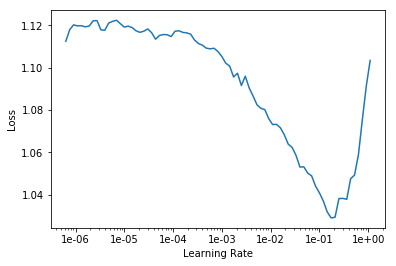

In [57]:
cl.recorder.plot()

In [58]:
cl.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.933656,0.912033,0.553149,00:15


In [0]:
cl.save('first')

In [60]:
cl.fit_one_cycle(2, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.933869,0.913679,0.541486,00:15
1,0.897614,0.906053,0.555148,00:16


In [0]:
cl.save('second')

In [62]:
cl.fit_one_cycle(5, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.908823,0.911874,0.558147,00:15
1,0.914773,0.911754,0.544485,00:15
2,0.893228,0.903819,0.556814,00:15
3,0.880916,0.901245,0.548484,00:14
4,0.867261,0.898458,0.557148,00:16
